In [1]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2024-01-27 21:29:30.532545: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# 3
train_image_generator = ImageDataGenerator(rescale=1/255) 
validation_image_generator = ImageDataGenerator(rescale=1/255) 
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                           batch_size=batch_size, 
                                                           class_mode='binary'
                                                          ) 

val_data_gen = validation_image_generator.flow_from_directory(validation_dir, 
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                              batch_size=batch_size, 
                                                              class_mode='binary'
                                                             ) 

test_data_gen = test_image_generator.flow_from_directory(test_dir, 
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                         batch_size=batch_size, 
                                                         class_mode='binary', 
                                                         shuffle=False
                                                        )

Found 2001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


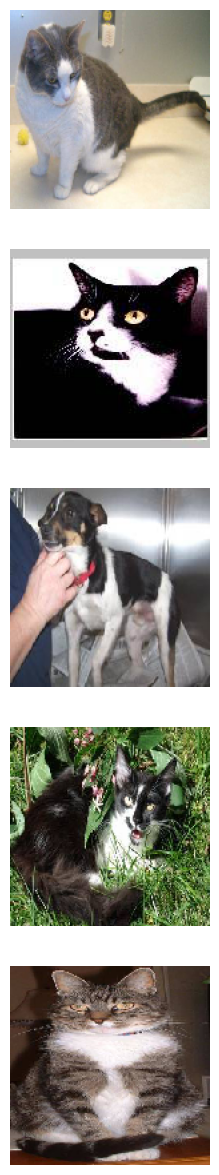

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [6]:
# 5
train_image_generator = ImageDataGenerator( 
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, zoom_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=True 
)

Found 2001 images belonging to 2 classes.


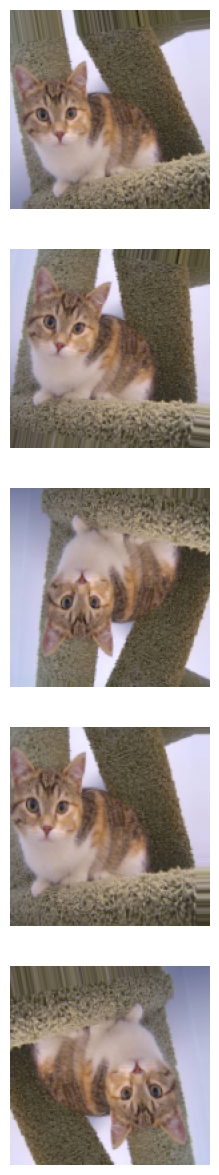

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [21]:
# 7
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 36, 36, 64)       

In [22]:
# 8
history = model.fit(train_data_gen, 
          steps_per_epoch=total_train // batch_size, 
          epochs=epochs, 
          validation_data=val_data_gen, 
          validation_steps=total_val // batch_size
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/15
15/15 [==============================] - 19s 1s/step - loss: 0.6998 - accuracy: 0.4949 - val_loss: 0.6944 - val_accuracy: 0.4933
Epoch 2/15
15/15 [==============================] - 19s 1s/step - loss: 0.6917 - accuracy: 0.5163 - val_loss: 0.6905 - val_accuracy: 0.5045
Epoch 3/15
15/15 [==============================] - 20s 1s/step - loss: 0.6931 - accuracy: 0.5141 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 4/15
15/15 [==============================] - 20s 1s/step - loss: 0.6899 - accuracy: 0.5190 - val_loss: 0.6894 - val_accuracy: 0.5257
Epoch 5/15
15/15 [==============================] - 20s 1s/step - loss: 0.6903 - accuracy: 0.5248 - val_loss: 0.6899 - val_accuracy: 0.5502
Epoch 6/15
15/15 [==============================] - 19s 1s/step - loss: 0.6907 - accuracy: 0.5147 - val_loss: 0.6914 - val_accuracy: 0.5234
Epoch 7/15
15/15 [==============================] - 19s 1s/step - loss: 0.6873 - accuracy: 0.5467 - val_loss: 0.6891 - val_accuracy: 0.5558
Epoch 8/15
15/15 [==

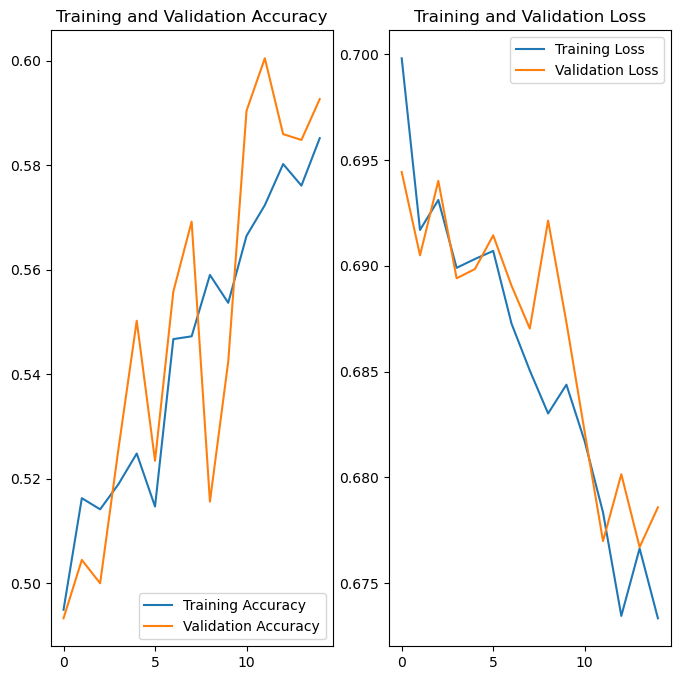

In [23]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 305ms/step


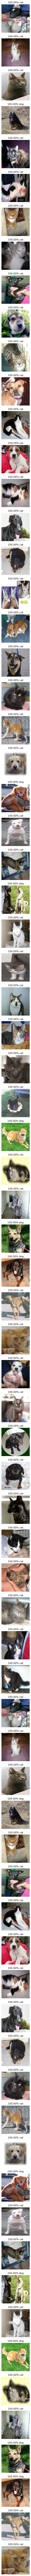

In [24]:
# 10
# from tensorflow.keras.preprocessing import image

# # Load an image for prediction
# img_path = test_dir + "/test/"
# img = image.load_img(img_path + "45.jpg", target_size=(150, 150))
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)
# img_tensor /= 255.

# # Generate predictions
# prediction = model.predict(img_tensor)
# if prediction >= 0.5:
#     print("It's a dog!")
# else:
#     print("It's a cat!")
    
# probabilities = model.predict(test_data_gen)
# # print(probabilities)
# probabilities = np.argmax(probabilities, axis=1)
# print(probabilities)

predictions = model.predict(test_data_gen)
probabilities = predictions.ravel()
classes = np.where(probabilities > 0.5, 1, 0)

plotImages(test_data_gen[0][0], classes)  # Pass the classes as labels

In [25]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
